# Fine-tune masked ruBERT-tiny2

Загружаем библиотеки

In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer, AutoModel
from datasets import Dataset
import evaluate

Загружаем отобранные предложения. Предложения отбираются в скрипте precorrect.py

In [2]:
with open('CorrectDN.json', encoding="utf-8") as f:
    sentences = pd.read_json(f, orient='records')
sentences.tail()

text  label
2931  Эксперт: морги Харькова переполнены телами укр...      1
2932  "Архитектор антироссийских санкций" возвращает...      1
2933  В Минздраве рассказали о состоянии пострадавши...      1
2934  Стало известно, какое оружие Украина захотела ...      1
2935  Евросоюз сократил закупки нефти и газа из Росс...      1

Собираем dataset

In [3]:
raw_ds = Dataset.from_pandas(sentences, preserve_index=False)
raw_ds = raw_ds.class_encode_column('label')
raw_ds.features

Stringifying the column:   0%|          | 0/2936 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2936 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['1'], id=None)}

Делим dataset на train и test (80:20)

In [4]:
raw_ds = raw_ds.train_test_split(test_size=0.2, shuffle=True)

In [5]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

model_checkpoint = "cointegrated/rubert-tiny2"
# model_checkpoint = "DeepPavlov/rubert-base-cased"
# model_checkpoint = "ai-forever/ruBert-base"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [6]:
text = "После начала российской военной [MASK] на Украине западные страны усилили санкционное давление на Москву."

In [7]:
import torch

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
#print (inputs)
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
# print (mask_token_index)
mask_token_logits = token_logits[0, mask_token_index, :]

# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

word = "спецоперации"
iii = tokenizer(word, return_tensors="pt")
masked_token = iii["input_ids"][0][1].item()
print("Masked token id: ", tokenizer.mask_token_id)
print ("Masked token: ", masked_token)

probs = torch.nn.functional.softmax(mask_token_logits, dim=1)

print ("Probability of masked token: ", probs[0][masked_token])

top_5_prob = torch.topk(probs, 5, dim=1)
val = top_5_prob.values[0].tolist()
ind = top_5_prob.indices[0].tolist()
for i in range(len(val)):
    print (f"'>>> {tokenizer.decode([ind[i]])} ({ind[i]})  >>>>: {val[i]}")
print ("-----------------")



# for i in range(len(val_all)):
#     if ind[i] == 17627:
#         print (f"'>>> {tokenizer.decode([ind_all[i]])}  >>>>: {val_all[i]}")

#for token in top_5_tokens:
#    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}' {token}")

Masked token id:  4
Masked token:  61407
Probability of masked token:  tensor(7.5576e-07, grad_fn=<SelectBackward0>)
'>>> службы (10969)  >>>>: 0.10426755994558334
'>>> операции (11394)  >>>>: 0.083821140229702
'>>> политики (17480)  >>>>: 0.07973532378673553
'>>> силы (11885)  >>>>: 0.06277793645858765
'>>> кампании (22938)  >>>>: 0.047023434191942215
-----------------


In [8]:
import re

s = "Как говорится в сообщении, Маск сможет оспорить соответствующее решение в следующей инстанции, а судья, постановившая, что повестку требуется исполнить, изменила свою позицию на рекомендательную."
maskToken = "[MASK]"
p = re.compile(r'[\w-]+')
iter = p.finditer(s)
nw = 0
hit = 0
for match in iter:
    nw += 1
    if match.start() == 0:
        masktext = maskToken + s[match.end():]
    elif match.end() == len(s):
        masktext = s[:match.start()] + maskToken
    else:
        masktext = s[:match.start()] + maskToken + s[match.end():]
    inputs = tokenizer(masktext, return_tensors="pt")
    token_logits = model(**inputs).logits
    # Find the location of [MASK] and extract its logits
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
    mask_token_logits = token_logits[0, mask_token_index, :]
    # Pick the [MASK] candidates with the highest logits
    top_1_tokens = torch.topk(mask_token_logits, 1, dim=1).indices[0].tolist()
   
    mt = tokenizer(match.group(), return_tensors="pt")
    masked_token = mt["input_ids"][0][1].item()
    if masked_token == top_1_tokens[0]:
        hit += 1
ratio = 1-hit/nw
print("Ratio: ", ratio)



Ratio:  0.7083333333333333


Tokenized dataset

In [9]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

# Use batched=True to activate fast multithreading!
tokenized_datasets = raw_ds.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

Map:   0%|          | 0/2348 [00:00<?, ? examples/s]

Map:   0%|          | 0/588 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 2348
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 588
    })
})

(array([ 19.,  75., 130., 193., 238., 251., 234., 230., 211., 170., 134.,
         94.,  71.,  59.,  32.,  37.,  35.,  27.,  18.,  20.,  12.,  12.,
          9.,   7.,   0.,   8.,   3.,   1.,   5.,   1.,   0.,   3.,   0.,
          0.,   0.,   1.,   2.,   1.,   2.,   0.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([  45.  ,   72.84,  100.68,  128.52,  156.36,  184.2 ,  212.04,
         239.88,  267.72,  295.56,  323.4 ,  351.24,  379.08,  406.92,
         434.76,  462.6 ,  490.44,  518.28,  546.12,  573.96,  601.8 ,
         629.64,  657.48,  685.32,  713.16,  741.  ,  768.84,  796.68,
         824.52,  852.36,  880.2 ,  908.04,  935.88,  963.72,  991.56,
        1019.4 , 1047.24, 1075.08, 1102.92, 1130.76, 1158.6 , 1186.44,
        1214.28, 1242.12, 1269.96, 1297.8 , 1325.64, 1353.48, 1381.32,
        1409.16, 1437.  ]),
 <BarContainer object of 50 artists>)

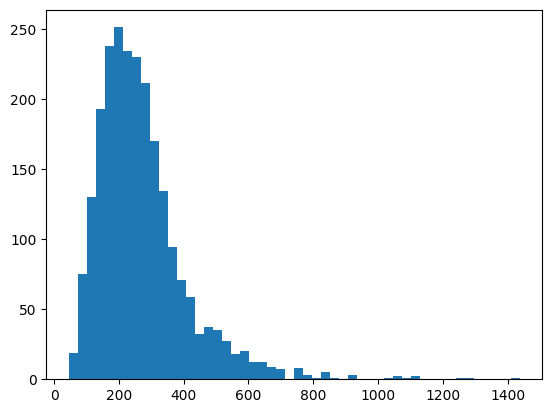

In [10]:
from matplotlib import pyplot as plt
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets["train"]
lenlist = []
for idx, sample in enumerate(tokenized_samples["input_ids"]):
    lenlist.append(len(sample))
fig, ax = plt.subplots()
ax.hist(lenlist, 50)

Chank size (Parameter!!!)

In [11]:
chunk_size = 256

In [12]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [13]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)

print (lm_datasets["test"])
print (lm_datasets["test"]["input_ids"])
print (lm_datasets["test"]["token_type_ids"])
print (lm_datasets["test"]["attention_mask"])
print (lm_datasets["test"]["word_ids"])
print (lm_datasets["test"]["labels"])

Map:   0%|          | 0/2348 [00:00<?, ? examples/s]

Map:   0%|          | 0/588 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 614
})
[[2, 299, 14095, 22591, 50938, 13661, 33710, 34067, 18, 79022, 14080, 35266, 3330, 17, 280, 29540, 4845, 23621, 16, 21, 332, 2535, 17, 31721, 31016, 18, 44596, 13854, 38166, 9906, 50938, 314, 67832, 46476, 53348, 1668, 34067, 331, 14095, 22591, 16, 1977, 38225, 2788, 31730, 2480, 18, 6, 13552, 11063, 32104, 329, 24619, 16, 24683, 1635, 2647, 30716, 16, 2371, 24478, 31288, 32248, 15273, 18, 18, 18, 19712, 30466, 8638, 30885, 16, 30099, 21211, 16, 6499, 30813, 6, 16, 17, 20412, 31721, 31016, 22745, 7200, 6, 73553, 33286, 866, 6, 26444, 721, 33811, 27092, 7853, 18, 35920, 1154, 48944, 54158, 4443, 15640, 7672, 49518, 16, 2938, 2710, 866, 24820, 42831, 548, 70258, 16, 3771, 3057, 769, 43178, 21607, 35552, 705, 41151, 18, 282, 28527, 31608, 66996, 320, 64547, 21311, 329, 52817, 18, 61941, 2762, 2480, 16, 29583, 38052, 19399, 18, 282, 12658, 24101, 6145, 18286, 30915, 1241, 3

Процент маскирования = 15% (Parameter!!!)

In [14]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

whole word masking, процент маскирования = 15% (Parameter!!!)

In [15]:
import collections
import numpy as np

from transformers import default_data_collator

wwm_probability = 0.15


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels

    return default_data_collator(features)

Маскирование всего набора за раз

In [16]:
def insert_random_mask(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

In [17]:
lm_datasets = lm_datasets.remove_columns(["word_ids"])
eval_dataset = lm_datasets["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=lm_datasets["test"].column_names,
)
eval_dataset = eval_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels",
        "masked_token_type_ids": "token_type_ids"
    }
)
eval_dataset
print (eval_dataset["input_ids"])
print (eval_dataset["attention_mask"])
print (eval_dataset["labels"])
print (eval_dataset["token_type_ids"])

Map:   0%|          | 0/614 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


[[2, 299, 14095, 22591, 50938, 13661, 33710, 34067, 18, 79022, 4, 35266, 3330, 17, 280, 29540, 4845, 23621, 16, 21, 332, 2535, 17, 31721, 31016, 18, 4, 13854, 38166, 9906, 50938, 314, 67832, 46476, 53348, 1668, 34067, 331, 14095, 4, 16, 1977, 38225, 4, 31730, 2480, 18, 6, 13552, 4, 4, 329, 24619, 16, 24683, 1635, 4, 30716, 16, 2371, 24478, 31288, 32248, 15273, 18, 18, 18, 19712, 30466, 4, 4, 16, 30099, 4, 4, 4, 30813, 6, 16, 17, 20412, 31721, 31016, 22745, 7200, 4, 73553, 33286, 866, 6, 26444, 721, 33811, 4, 7853, 18, 35920, 1154, 48944, 54158, 4443, 15640, 4, 4, 16, 2938, 2710, 4, 24820, 42831, 548, 70258, 16, 4, 3057, 769, 43178, 21607, 35552, 705, 41151, 18, 282, 28527, 31608, 66996, 320, 64547, 21311, 329, 52817, 18, 61941, 2762, 2480, 16, 4, 4, 19399, 18, 282, 12658, 24101, 6145, 18286, 30915, 1241, 36645, 326, 2445, 4, 1242, 38757, 753, 4, 69030, 4, 16843, 16, 3057, 40479, 12729, 2749, 33119, 320, 42597, 47267, 35408, 33006, 18, 4, 24449, 1610, 60796, 314, 4, 67488, 16, 31950, 11

inputs_ids содержит маскированные данные (токен маски = 4), labels содержит токены под маской

Batch_size (Parameter!!!)

In [18]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

batch_size = 16
train_dataloader = DataLoader(
    lm_datasets["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
    # collate_fn=whole_word_masking_data_collator
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, collate_fn=default_data_collator
)

LOSS function definition

In [20]:
import torch
import torch.nn as nn


i = 0
cross_entropy_loss = nn.CrossEntropyLoss(reduction='sum')

for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)
        # print (tokenizer.decode([batch["labels"][0][7].item()]))
        # probs = nn.functional.softmax(outputs.logits[0][7], dim=-1)
        # print (probs[batch["labels"][0][7].item()])

        print ("Loss: ", outputs.loss)
        # print (outputs.logits.shape)
        # print (batch["labels"].shape)
        # ooo = torch.topk(outputs.logits, k=1, dim=2)
        # print (ooo.values.shape)
        # print (ooo.indices.shape)
        print (outputs.logits.view(-1, tokenizer.vocab_size).shape)
        print (batch["labels"].view(-1).shape)
        loss2 = cross_entropy_loss(outputs.logits.view(-1, tokenizer.vocab_size), batch["labels"].view(-1))
        print ("Loss2: ", loss2)
        print (tokenizer.vocab_size)

        # print (cel)
        i += 1
        if i == 1:
            break

Loss:  tensor(2.8829)
torch.Size([4096, 83828])
torch.Size([4096])
Loss2:  tensor(1827.7660)
83828


Optimizer (Parameter!!!)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
output_dir = 'fine-train'

In [ ]:
from tqdm.auto import tqdm
import torch
import math

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))

    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)